#### IMPORTS

In [1]:
import torch
import numpy as np

from dataloader import MyCustomDataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

import os
from model_nn import  Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
default_dir = os.getcwd()
def default_directory():
    os.chdir(f"{default_dir}")
    print(f"you are back to the default directory: {default_dir}")


In [3]:
default_directory()
os.getcwd()

you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN


'/home/karansingh/Documents/summer-term/ECG_ML/MAIN'

In [4]:
os.chdir("../../KARAN_ECG/ML/data_200*200_cg")
os.getcwd()

'/home/karansingh/Documents/summer-term/KARAN_ECG/ML/data_200*200_cg'

#### LOAD DATA

In [5]:
## Create fake dataset for demonstration purposes

## Load your dataset and use 
#KARAN_ECG/ML/data_200*200_cg/disease_SB_cg200_svd_0.txt

data_ST_list = []
for i in range(10):
    cc = np.loadtxt('disease_ST_cg200_svd_'+str(i)+'.txt')
    if i==0:
        print(cc.shape)
    data_ST_list.append(cc)
    print(f"data st of length {len(cc)} in {i} index loaded")


data_ST_list = np.array(data_ST_list)
images = np.resize(data_ST_list,(5000,40000))

labels=np.zeros(5000)

data_SB_list = []
for i in range(10):
    cc = np.loadtxt('disease_SB_cg200_svd_'+str(i)+'.txt')
    data_SB_list.append(cc)
    if i==0:
        print(cc.shape)
    print(f"data sb of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SB_list,(5000,40000))))
labels=np.concatenate((labels,np.ones(5000)))

data_SR_list = []
for i in range(10):
    cc = np.loadtxt('disease_SR_cg200_svd_'+str(i)+'.txt')
    data_SR_list.append(cc)
    if i==0:
        print(cc.shape)
    print(f"data sr of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SR_list,(5000,40000))))
labels=np.concatenate((labels,np.ones(5000)*2))
                    

(500, 40000)
data st of length 500 in 0 index loaded
data st of length 500 in 1 index loaded
data st of length 500 in 2 index loaded
data st of length 500 in 3 index loaded
data st of length 500 in 4 index loaded
data st of length 500 in 5 index loaded
data st of length 500 in 6 index loaded
data st of length 500 in 7 index loaded
data st of length 500 in 8 index loaded
data st of length 500 in 9 index loaded
(500, 40000)
data sb of length 500 in 0 index loaded
data sb of length 500 in 1 index loaded
data sb of length 500 in 2 index loaded
data sb of length 500 in 3 index loaded
data sb of length 500 in 4 index loaded
data sb of length 500 in 5 index loaded
data sb of length 500 in 6 index loaded
data sb of length 500 in 7 index loaded
data sb of length 500 in 8 index loaded
data sb of length 500 in 9 index loaded
(500, 40000)
data sr of length 500 in 0 index loaded
data sr of length 500 in 1 index loaded
data sr of length 500 in 2 index loaded
data sr of length 500 in 3 index loaded
d

In [6]:
default_directory()
print(len(images),len(labels))
from model_cnn import SmallCNN
print(images.shape)
images = images.reshape(15000,1,200,200)
images.shape



you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN
15000 15000
(15000, 40000)


(15000, 1, 200, 200)

#### CREATE BATCHES

In [7]:
# Create an instance of your dataset

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = MyCustomDataset(images_train, labels_train)
test_dataset = MyCustomDataset(images_test, labels_test)
# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### TRAINING PARAMETERS

In [8]:
temp=train_dataset[0]

In [9]:
import torch.nn.functional as F

class oimodel(nn.Module):
    def __init__(self):
        super(oimodel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, 3)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU, batch norm, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: 100x100
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: 50x50
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Output: 25x25
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 25 * 25)
        
        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [10]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Print the memory usage
def print_memory_usage():
    allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
    reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
    print(f"Memory Allocated: {allocated:.2f} MiB")
    print(f"Memory Reserved: {reserved:.2f} MiB")

# Example usage
print_memory_usage()

Memory Allocated: 0.00 MiB
Memory Reserved: 0.00 MiB


In [11]:
torch.cuda.empty_cache()


#### TRAINING

In [12]:
#orignal
torch.manual_seed(42)  # Set seed for reproducibility
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model__ = oimodel().to(device)

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(model__.parameters(), lr=0.001)  
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

num_epochs = 25
test_losses_list = []
train_losses_list = []
accuracy_train_list = []
accuracy_test_list = []

for epoch in range(num_epochs):
    model__.train()
    running_loss, accuracy_train = 0.0, 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model__(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        accuracy_train += accuracy(labels, outputs.argmax(dim=1))
    train_losses_list.append(running_loss / len(train_dataloader))
    
    # Just calculating the test loss and accuracy
    with torch.no_grad():
        model__.eval()
        test_loss, accuracy_test = 0.0, 0.0
        for i, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model__(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            accuracy_test += accuracy(labels, outputs.argmax(dim=1))
    test_losses_list.append(test_loss / len(test_dataloader))
    
    accuracy_train_list.append(accuracy_train / len(train_dataloader))
    accuracy_test_list.append(accuracy_test / len(test_dataloader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}, Train Accuracy: {accuracy_train / len(train_dataloader):.4f}, Test Accuracy: {accuracy_test / len(test_dataloader):.4f}')

Epoch [1/25], Train Loss: 0.4584, Test Loss: 0.1640, Train Accuracy: 79.8500, Test Accuracy: 94.6000
Epoch [2/25], Train Loss: 0.1887, Test Loss: 0.1305, Train Accuracy: 93.5917, Test Accuracy: 95.8000
Epoch [3/25], Train Loss: 0.1497, Test Loss: 0.1237, Train Accuracy: 94.9917, Test Accuracy: 96.0667
Epoch [4/25], Train Loss: 0.1255, Test Loss: 0.1445, Train Accuracy: 95.7500, Test Accuracy: 95.5667
Epoch [5/25], Train Loss: 0.1125, Test Loss: 0.1153, Train Accuracy: 96.4167, Test Accuracy: 96.2333
Epoch [6/25], Train Loss: 0.0940, Test Loss: 0.1260, Train Accuracy: 96.7417, Test Accuracy: 96.4333
Epoch [7/25], Train Loss: 0.0841, Test Loss: 0.1078, Train Accuracy: 97.1583, Test Accuracy: 96.6333
Epoch [8/25], Train Loss: 0.0707, Test Loss: 0.1359, Train Accuracy: 97.6083, Test Accuracy: 96.6333
Epoch [9/25], Train Loss: 0.0624, Test Loss: 0.1379, Train Accuracy: 97.7500, Test Accuracy: 96.4333
Epoch [10/25], Train Loss: 0.0617, Test Loss: 0.1197, Train Accuracy: 97.8583, Test Accurac

In [13]:
#batch size of dataloader check
print(len(train_dataloader))
print(len(test_dataloader))

6000
1500


In [14]:
# save the model
default_directory()
torch.save(model__.state_dict(), 'model_smallCNN_200_v0.pth')



you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN


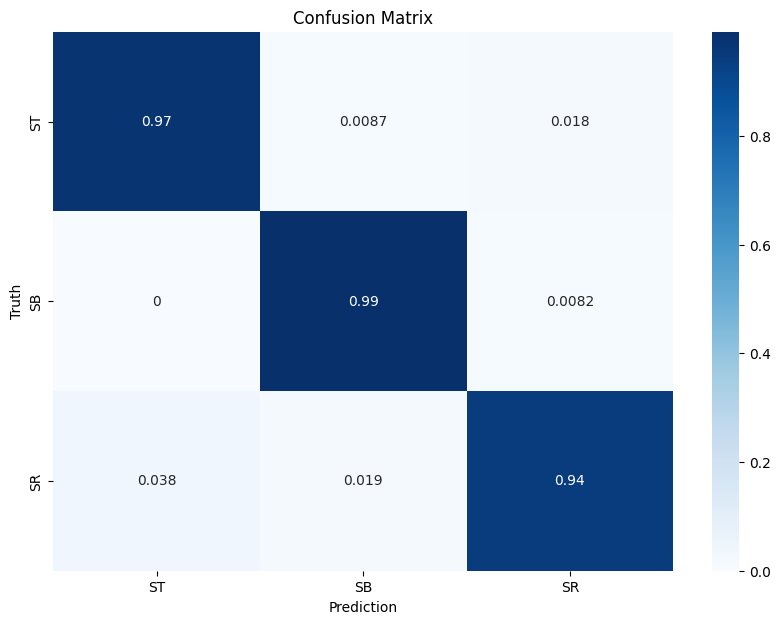

In [15]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

model__.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model__(images.to(device))
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
df_cm = pd.DataFrame(cm, index=["ST", "SB", "SR"], columns=["ST", "SB", "SR"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()




In [16]:

#Classification Report for Test Data:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["ST", "SB", "SR"]))


              precision    recall  f1-score   support

          ST       0.96      0.97      0.97      1037
          SB       0.97      0.99      0.98       970
          SR       0.97      0.94      0.96       993

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



Average precision score, micro-averaged over all classes: 0.95


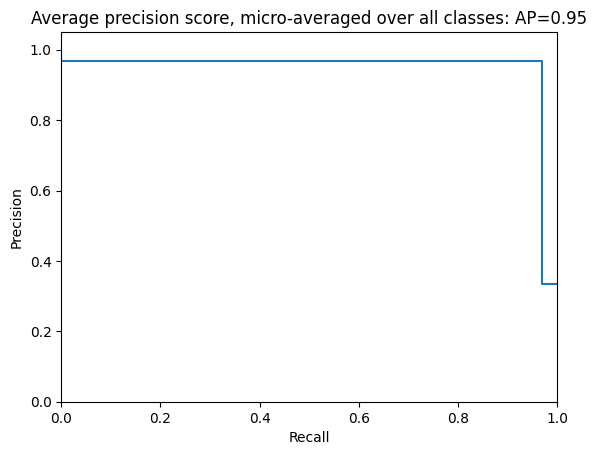

In [17]:
# presicion recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve((np.array(y_true) == i).astype(int),
                                                        (np.array(y_pred) == i).astype(int))
    average_precision[i] = average_precision_score((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(np.eye(3)[y_true].ravel(),
    np.eye(3)[y_pred].ravel())
average_precision["micro"] = average_precision_score(np.eye(3)[y_true], np.eye(3)[y_pred],
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.show()

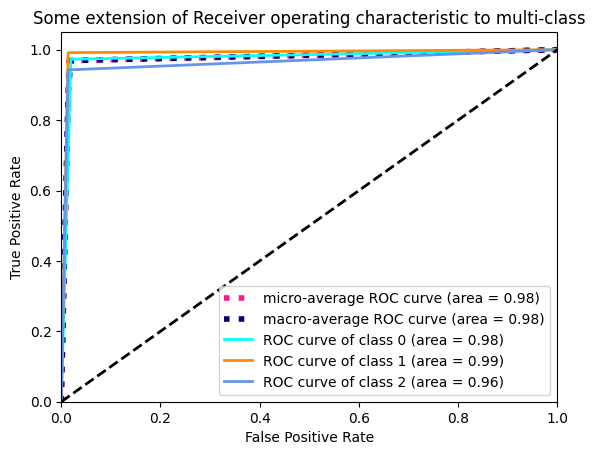

In [18]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_score = label_binarize(y_pred, classes=[0, 1, 2])


n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



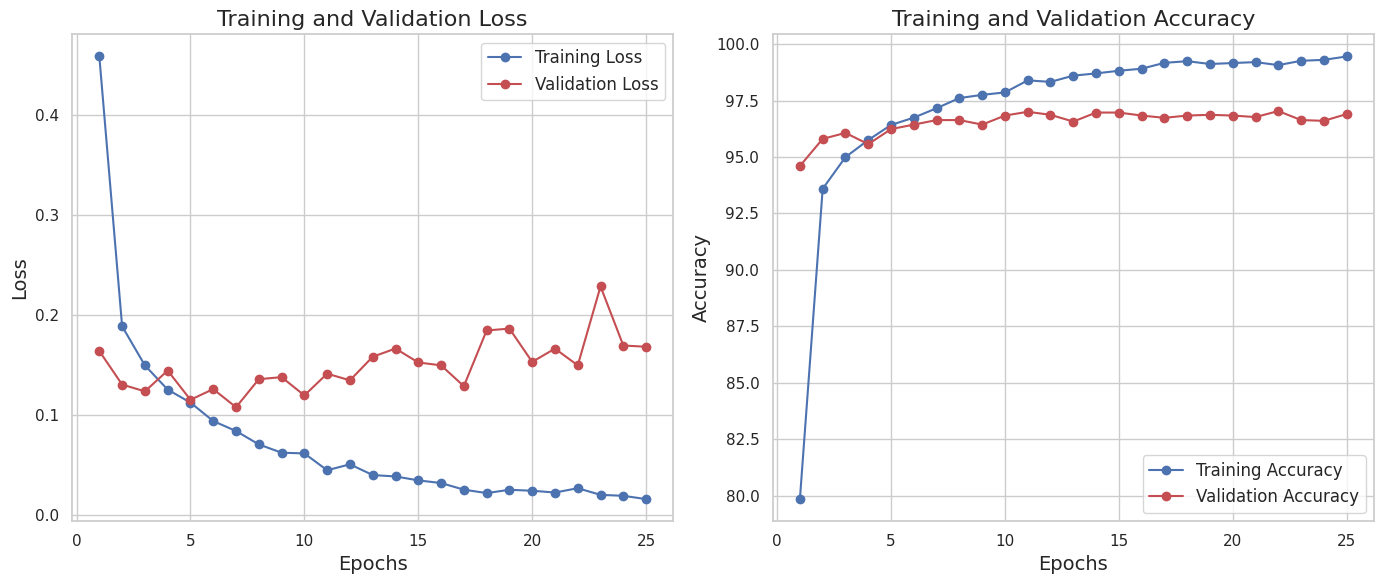

In [19]:
from plots import accuracy_and_validation_plots


# Example data: Replace these with your actual training and validation data
epochs_= list(range(1, len(train_losses_list)+1))

accuracy_and_validation_plots(epochs_, train_losses_list, test_losses_list, accuracy_train_list,accuracy_test_list).plot_figure("accuracy.png")


In [20]:
def model_train(train_dataloader, test_dataloader,n):
    torch.manual_seed(n)  # Set seed for reproducibility
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model__ = Model().to(device)

    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.Adam(model__.parameters(), lr=0.001)  # Adam optimizer

    def accuracy(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

    num_epochs = 25
    test_losses_list = []
    train_losses_list = []
    accuracy_train_list = []
    accuracy_test_list = []

    for epoch in range(num_epochs):
        model__.train()
        running_loss, accuracy_train = 0.0, 0.0
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model__(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy_train += accuracy(labels, outputs.argmax(dim=1))
        train_losses_list.append(running_loss / len(train_dataloader))
        
        # Just calculating the test loss and accuracy
        with torch.no_grad():
            model__.eval()
            test_loss, accuracy_test = 0.0, 0.0
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                outputs = model__(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                accuracy_test += accuracy(labels, outputs.argmax(dim=1))
        test_losses_list.append(test_loss / len(test_dataloader))
        
        accuracy_train_list.append(accuracy_train / len(train_dataloader))
        accuracy_test_list.append(accuracy_test / len(test_dataloader))

        #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}, Train Accuracy: {accuracy_train / len(train_dataloader):.4f}, Test Accuracy: {accuracy_test / len(test_dataloader):.4f}')
    return train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list

In [21]:
from model_cnn import SmallCNN

